In [1]:
import collections
import gc
from typing import Iterator, List

import nest_asyncio
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2022-03-13 16:49:52.687464: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-13 16:49:52.687479: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Table of Contents

- [Step 1](#Step-1)
- [Step 2](#Step-2-+-Step-3)
- [Step 3](#Step-2-+-Step-3)
- [Step 4](#Step-4)
- [Step 5](#Step-5)
- [Step 6](#Step-6)
- [Step 7](#Step-4)
- [Step 8](#Step-5)
- [Step 9](#Step-6)
- [Step 10](#Step-10)

In [2]:
# dataset source: https://grouplens.org/datasets/movielens/
# !wget --backups=1 https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -P data/

In [3]:
# if `unzip` does not exist in your system: apt-get install unzip
# !unzip data/ml-latest-small.zip -d data/

In [4]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

## Step 1

In [5]:
# Formulate the optimization problem (similarly to the formulation in Unit 5). Your
# optimization problem will relate to the prediction error in the training dataset.
# Make sure you understand the unknowns of the problem, and what you are trying to optimize.

## Step 2 + Step 3

In [6]:
ratings = pd.read_csv("data/ml-latest-small/ratings.csv")

inspect_df(ratings)

shape: (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
ratings["movieId"] = ratings.groupby("movieId").ngroup()

In [8]:
trainset, testset = train_test_split(ratings, test_size=0.2, shuffle=True)

In [9]:
trainset, validationset = train_test_split(trainset, test_size=0.1, shuffle=True)

In [10]:
trainset.shape

(72601, 4)

In [11]:
testset.shape

(20168, 4)

In [12]:
validationset.shape

(8067, 4)

## Step 4

In [13]:
def clean_up(model_):
    tf.keras.backend.clear_session()
    del model_
    gc.collect()

In [14]:
n_users = len(ratings["userId"].unique())
n_items = len(ratings["movieId"].unique())

In [15]:
users_vector = np.asarray(ratings["userId"]).astype(np.int32)
items_vector = np.asarray(ratings["movieId"]).astype(np.int32)

In [16]:
n_users

610

In [17]:
n_items

9724

In [18]:
users_vector.shape

(100836,)

In [19]:
items_vector.shape

(100836,)

In [20]:
X = np.array([users_vector, items_vector]).T

X.shape

(100836, 2)

In [21]:
y = ratings["rating"].values

y.shape

(100836,)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [23]:
tf.keras.backend.clear_session()

In [24]:
def mf_model(
    n_users: int,
    n_items: int,
    n_latent_factors: int,
) -> tf.keras.Model:
    """A Matrix Factorization model."""
    users_input = tf.keras.layers.Input(shape=[1], dtype="int32", name="users_input")
    u = tf.keras.layers.Embedding(
        input_dim=n_users + 1, output_dim=n_latent_factors, name="users_embedding"
    )(users_input)
    u = tf.keras.layers.Flatten()(u)

    items_input = tf.keras.layers.Input(shape=[1], dtype="int32", name="items_input")
    i = tf.keras.layers.Embedding(
        input_dim=n_items + 1, output_dim=n_latent_factors, name="items_embedding"
    )(items_input)
    i = tf.keras.layers.Flatten()(i)

    output = tf.output_layer = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [i, u]
    )

    return tf.keras.Model(inputs=[users_input, items_input], outputs=output)

In [25]:
mf_model_small = mf_model(
    n_users=n_users,
    n_items=n_items,
    n_latent_factors=4,
)

2022-03-13 16:49:54.965138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 16:49:54.965495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-13 16:49:54.965590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-13 16:49:54.965679: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-13 16:49:54.967736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [26]:
mf_model_small.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.SGD(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

In [27]:
mf_model_small.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 items_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 users_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 items_embedding (Embedding)    (None, 1, 4)         38900       ['items_input[0][0]']            
                                                                                                  
 users_embedding (Embedding)    (None, 1, 4)         2444        ['users_input[0][0]']            
                                                                                              

In [28]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True
)

In [29]:
history = mf_model_small.fit(
    [X_train[:, 0], X_train[:, 1]],
    y_train,
    epochs=100,
    validation_split=0.1,
    batch_size=512,
    callbacks=[callback],
)

Epoch 1/100
142/142 [==============================] - 1s 2ms/step - loss: 13.3622 - root_mean_squared_error: 3.6554 - val_loss: 13.3347 - val_root_mean_squared_error: 3.6517
Epoch 2/100
142/142 [==============================] - 0s 1ms/step - loss: 13.3622 - root_mean_squared_error: 3.6554 - val_loss: 13.3347 - val_root_mean_squared_error: 3.6517
Epoch 3/100
142/142 [==============================] - 0s 1ms/step - loss: 13.3622 - root_mean_squared_error: 3.6554 - val_loss: 13.3347 - val_root_mean_squared_error: 3.6517
Epoch 4/100
142/142 [==============================] - 0s 1ms/step - loss: 13.3622 - root_mean_squared_error: 3.6554 - val_loss: 13.3347 - val_root_mean_squared_error: 3.6517
Epoch 5/100
142/142 [==============================] - 0s 1ms/step - loss: 13.3622 - root_mean_squared_error: 3.6554 - val_loss: 13.3347 - val_root_mean_squared_error: 3.6517
Epoch 6/100
142/142 [==============================] - 0s 1ms/step - loss: 13.3622 - root_mean_squared_error: 3.6554 - val_lo

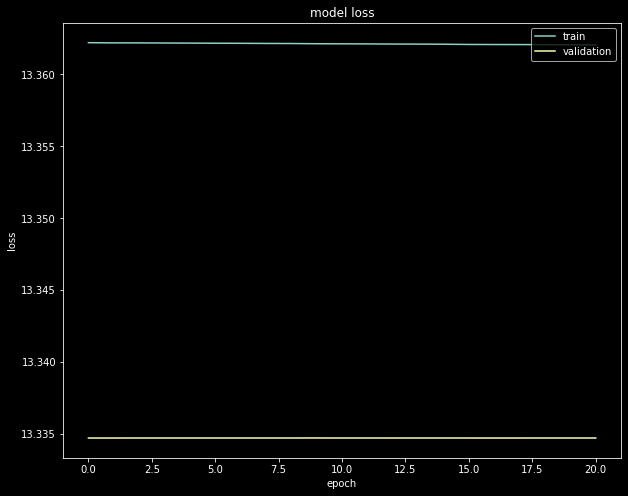

In [30]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")
plt.show()

In [31]:
evaluation = mf_model_small.evaluate(
    x=[X_test[:, 0], X_test[:, 1]], y=y_test, verbose=1
)

631/631 [==============================] - 0s 695us/step - loss: 13.3011 - root_mean_squared_error: 3.6471


In [32]:
mse = evaluation[0]
rmse = evaluation[1]

print("Test MSE = " + str(mse))
print("Test RMSE = " + str(rmse))

Test MSE = 13.301095962524414
Test RMSE = 3.647066831588745


In [33]:
clean_up(model_=mf_model_small)

In [34]:
mf_model_big = mf_model(
    n_users=n_users,
    n_items=n_items,
    n_latent_factors=20,
)

In [35]:
mf_model_big.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.SGD(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

In [36]:
mf_model_big.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 items_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 users_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 items_embedding (Embedding)    (None, 1, 20)        194500      ['items_input[0][0]']            
                                                                                                  
 users_embedding (Embedding)    (None, 1, 20)        12220       ['users_input[0][0]']            
                                                                                              

In [37]:
history = mf_model_big.fit(
    [X_train[:, 0], X_train[:, 1]],
    y_train,
    epochs=100,
    validation_split=0.1,
    batch_size=512,
    callbacks=[callback],
)

Epoch 1/100
142/142 [==============================] - 0s 2ms/step - loss: 13.3622 - root_mean_squared_error: 3.6554 - val_loss: 13.3345 - val_root_mean_squared_error: 3.6516
Epoch 2/100
142/142 [==============================] - 0s 1ms/step - loss: 13.3621 - root_mean_squared_error: 3.6554 - val_loss: 13.3345 - val_root_mean_squared_error: 3.6516
Epoch 3/100
142/142 [==============================] - 0s 1ms/step - loss: 13.3621 - root_mean_squared_error: 3.6554 - val_loss: 13.3345 - val_root_mean_squared_error: 3.6516
Epoch 4/100
142/142 [==============================] - 0s 1ms/step - loss: 13.3621 - root_mean_squared_error: 3.6554 - val_loss: 13.3345 - val_root_mean_squared_error: 3.6516
Epoch 5/100
142/142 [==============================] - 0s 1ms/step - loss: 13.3620 - root_mean_squared_error: 3.6554 - val_loss: 13.3345 - val_root_mean_squared_error: 3.6516
Epoch 6/100
142/142 [==============================] - 0s 1ms/step - loss: 13.3620 - root_mean_squared_error: 3.6554 - val_lo

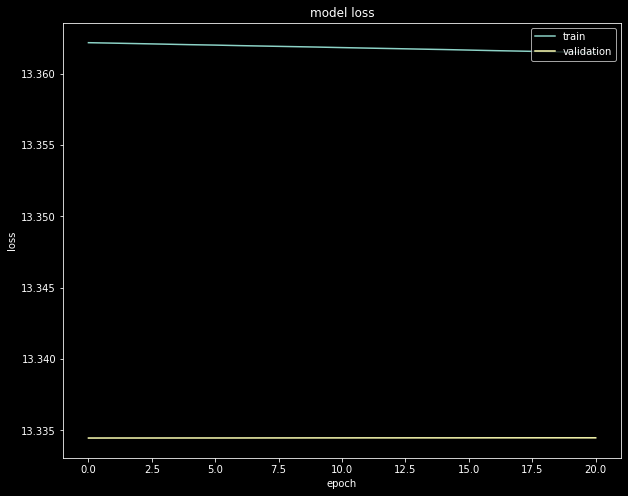

In [38]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")
plt.show()

In [39]:
evaluation = mf_model_big.evaluate(x=[X_test[:, 0], X_test[:, 1]], y=y_test, verbose=1)

631/631 [==============================] - 0s 733us/step - loss: 13.3011 - root_mean_squared_error: 3.6471


In [40]:
mse = evaluation[0]
rmse = evaluation[1]

print("Test MSE = " + str(mse))
print("Test RMSE = " + str(rmse))

Test MSE = 13.301148414611816
Test RMSE = 3.647073984146118


In [41]:
clean_up(model_=mf_model_big)

## Step 5

In [42]:
def create_tf_datasets(
    data: pd.DataFrame,
    batch_size: int = 1,
    max_clients: int = None,
    max_items_per_user: int = None,
) -> Iterator[tf.data.Dataset]:

    n_users = len(data["userId"].unique())

    if max_clients is not None:
        n_users = min(n_users, max_clients)

    def transform_batch(batch: tf.Tensor) -> collections.OrderedDict:

        return collections.OrderedDict(
            x=tf.cast(batch[:, 0:2], tf.int64), y=tf.cast(batch[:, 2:3], tf.float32)
        )

    for _, user_ratings in data.groupby("userId"):

        if n_users < 0:
            break

        tf_dataset = tf.data.Dataset.from_tensor_slices(user_ratings)

        yield (
            tf_dataset.take(max_items_per_user)
            .shuffle(buffer_size=max_items_per_user, seed=42)
            .batch(batch_size)
            .map(transform_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        )

        n_users -= 1

In [43]:
tf_trainsets = [
    *create_tf_datasets(
        data=trainset,
        batch_size=10,
        max_items_per_user=100,
        max_clients=75,
    )
]

In [44]:
tf_testsets = [
    *create_tf_datasets(
        data=testset,
        batch_size=10,
        max_items_per_user=100,
        max_clients=75,
    )
]

In [45]:
tf_validationsets = [
    *create_tf_datasets(
        data=validationset,
        batch_size=10,
        max_items_per_user=100,
        max_clients=75,
    )
]

In [46]:
print(next(iter(tf_trainsets[0])))

OrderedDict([('x', <tf.Tensor: shape=(10, 2), dtype=int64, numpy=
array([[   1, 2670],
       [   1,  968],
       [   1, 1690],
       [   1,  819],
       [   1,  257],
       [   1,  910],
       [   1, 1075],
       [   1,  510],
       [   1,  632],
       [   1,  919]])>), ('y', <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[5.],
       [5.],
       [4.],
       [5.],
       [3.],
       [5.],
       [3.],
       [4.],
       [4.],
       [2.]], dtype=float32)>)])


## Step 6

In [47]:
nest_asyncio.apply()

In [48]:
tff.federated_computation(lambda: "Hello, World!")()

b'Hello, World!'

In [51]:
def mf_model_federated_friendly(
    n_users: int,
    n_items: int,
    n_latent_factors: int,
) -> tf.keras.Model:
    """A Matrix Factorization model."""
    users_input = tf.keras.layers.Input(shape=[1], dtype="int32", name="users_input")
    u = tf.keras.layers.Embedding(
        input_dim=n_users + 1, output_dim=n_latent_factors, name="users_embedding"
    )(users_input)
    u = tf.keras.layers.Flatten()(u)

    items_input = tf.keras.layers.Input(shape=[1], dtype="int32", name="items_input")
    i = tf.keras.layers.Embedding(
        input_dim=n_items + 1, output_dim=n_latent_factors, name="items_embedding"
    )(items_input)
    i = tf.keras.layers.Flatten()(i)

    output = tf.output_layer = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [i, u]
    )

    return tf.keras.Model(inputs={"u": users_input, "i": items_input}, outputs=output)

In [52]:
def model_fn():
    model = mf_model_federated_friendly(
        n_users=n_users,
        n_items=n_items,
        n_latent_factors=20,
    )

    input_spec = collections.OrderedDict(
        x=collections.OrderedDict(
            u=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
            i=tf.TensorSpec(shape=[1, 1], dtype=tf.float32),
        ),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
    )

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

In [53]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
)

In [54]:
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<float32[9725,20],float32[611,20]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)'

In [56]:
state = iterative_process.initialize()


print(state.model)

ModelWeights(trainable=[array([[-0.04319402,  0.0325467 ,  0.04190444, ..., -0.04072454,
         0.04408764, -0.00631542],
       [-0.04419247, -0.00166304,  0.04124964, ..., -0.0327394 ,
        -0.01975687,  0.04468674],
       [ 0.02966041, -0.04290048, -0.02223184, ...,  0.02098917,
        -0.03825725,  0.02397263],
       ...,
       [-0.042977  , -0.01563779,  0.02137892, ..., -0.01634755,
         0.03314411, -0.04458243],
       [-0.00998217, -0.01574504,  0.03182587, ...,  0.04922159,
         0.04833105,  0.01125025],
       [ 0.03817749, -0.00263134,  0.01658211, ..., -0.03023446,
         0.01356489, -0.04812864]], dtype=float32), array([[-0.03514512,  0.04169538,  0.02672187, ...,  0.0343145 ,
        -0.03441912,  0.01694508],
       [ 0.04120226, -0.01954865, -0.04891283, ...,  0.00281511,
        -0.0271348 , -0.00950992],
       [-0.0418179 , -0.03312612, -0.01767952, ..., -0.02524296,
        -0.0304273 ,  0.04699684],
       ...,
       [ 0.02079207, -0.01911771,  

## Step 7

In [57]:
print("Item variables shape:", state.model.trainable[0].shape)
print("User variables shape:", state.model.trainable[1].shape)

Item variables shape: (9725, 20)
User variables shape: (611, 20)


## Step 8

## Step 9

## Step 10